In [1]:
import torch
import torchvision
import time
from torch import optim, nn
from importlib import reload
import numpy as np


import GPUtil

import sys
sys.path.insert(0,'..')

#############################################
## Copy of Inceptionv3, slightly modified for recording intermeridates
#sys.path.append('/home/cshetty2/sct/pytorch')
#import reformated_models.inception_modified as inception_modified

## Modified Alexnet, with a'factor' by which it can be made 'fat' 
#import simple_model as sm

## Placer libs of baechi
#sys.path.append('/home/cshetty2/sct')
#from placer.placer_lib import *
##############################################

import dummyModels as dm


######## For profiler (some experiments. Not required) #################
from torch.profiler import profile, record_function, ProfilerActivity



import matplotlib.pyplot as plt

######## For debug purposes ONLY ########
import ctypes, gc
import psutil, os

###############################Utilities#################################
### From https://discuss.pytorch.org/t/how-pytorch-releases-variable-garbage/7277
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)
        
## Print memory of all available GPU's
def print_gpu_memory():
    for i in range(torch.cuda.device_count()):
        #print(torch.cuda.get_device_name(i))
        print("GPU:", i)
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,8), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,8), 'GB')
        #print("-----------------")
        #GPUtil.showUtilization()
        print("-----------")
#########################################

%matplotlib inline
%load_ext autoreload
%autoreload 2

print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [2]:
import threading
from random import expovariate

Experiment aims to demonstrate the advantage of packing training jobs on GPU (based on the resource requirements) rather than allotting integer number of GPUs per job (as container based approach would do)

Measure: Throughput for these two cases and compare:
- (1) one GPU allocation for each incoming jobs on FCFS basis
- (2) decide a split of the incoming model among the two GPUs and run on best effort basis (the entire model maybe placed on one GPUs)

Expectation: (2) should be more than (1) for two reasons:
- granualr GPU allocation is more efficient
- the model choosen itself runs faster when split across 2 gpus than 1 as described in next section

Primitives:

- GPUs : Setup consists of only 2 GPUs on one node
- Jobs : All incoming jobs will be of same kind - to train a model dm.parallelModelThreeLayerSplit as described below
- Training Script: run_train() is the main training routine. When a job arrives, a split for the model among two GPU's is 
- Job queue: jobs arrive as poisson process. Job queue maintains the cluster state and allots jobs with appropriate split while preventing OOMs

### Training script

In [3]:
'''
run_train: train the dm.parallelModelThreeLayerSplit model using given settings

*****MODEL*******
- dm.parallelModelThreeLayerSplit: Looks as below
           ----|---|----                       .....Branch 1
          /             \
     | --- ----|---|---------|-----|--(output) .....Branch 2
    (L1)  \             /  (L3)   (L4)
           ----|---|----                       .....Branch 3
           
- On one GPU it runs as GPU1: (L1)(Branch1)(Branch2)(Branch3)(L3)(L4)
- On 2 GPU's it runs as GPU1: (L1)(Branch1)(Branch2)(L3)(L4)
                        GPU2:     (Branch3)
                        
- 2 GPU execution is about 20% faster
- Even when provided 3 GPUs, fitting in 2 GPUs gives least step time

-Inputs to the model:dm.parallelModelThreeLayerSplit(fct, model_split, repetable)
    -fct : Factor by which all the layers will be scaled. eg: fct =2 will doubble size of all layers
    -model_split : A list of ints [g1, g2]: g1, g2 are device ids for GPU1, GPU2 above
        - Though not exact, for this exp we assume [gpu1,gpu1] occupies 0.6 of gpu1, [gpu1,gpu2] occupies 0.3 of each gpu1 and gpu2
    -repetable : When repetable is non-zero, the model weights are initialized to 1/512 and biases to 0
******************

run_train arguments:
- model_split, fct: As described above
- batch_size: For training (done using fake dataset)
- Nrun: Number of batches (steps)
- done_flag: A singleton list (so that it is mutable) to indicate end of thread (contains avg step time)
- exit_time: Time when job is completed

'''

def run_train(job_id, model_split, fct, batch_size, Nrun, done_flag, exit_time ): 
    mysplit = job_queue[job_id]['model_split']
    
    inp_size_single = (1, 512*fct)
    model = dm.parallelModelThreeLayerSplit(fct, model_split, 0)
    
    inp_size = (batch_size,) + inp_size_single
    inp   = torch.ones(inp_size)
    output = model(inp)
    last_gpu = output.get_device()      ## GPU on which labbels should be placed for training
    opt_size = tuple(output.size())[1]

    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    criterion = nn.MSELoss()
    dataset = torchvision.datasets.FakeData(
        size= Nrun * batch_size,
        image_size=inp_size_single,
        num_classes=opt_size,
        transform=torchvision.transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    result = []


    times = []
    if 1:
    #with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:  
        for batch_idx, (inp, oup) in enumerate(data_loader):
            ## NOTE: If more GPUs are used, take care to sync them all!
            #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            labels = torch.randn((batch_size, opt_size)).to(last_gpu)
            start = time.time()
            optimizer.zero_grad()
            output = model(inp)
            #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            ######################### loss compute ################################################
            loss = criterion(output, labels )
            ##################################################################################
            loss.backward(loss)
            optimizer.step()
            
            #if 1 in mysplit: 
            #    torch.cuda.synchronize(1);
            #if 2 in mysplit:
            #    torch.cuda.synchronize(2);
            out_cpu = output.cpu()
            end = time.time()
            times.append(1000*(end-start))
    #prof.export_chrome_trace("trace_split.json")
    if len(times)>10:
        gpu_time = np.mean(times[10:])
    else:
        gpu_time = True
    
    #### Release memory
    del model
    del inp
    del output
    try:
        del labels
        del optimizer
        del loss
    except: pass
    gc.collect()              ## To clean any circular references
    torch.cuda.empty_cache() ## Empty cache used by Pytorch (does so across all threads)
    #print_gpu_memory()
    done_flag[0] = gpu_time
    exit_time[0] = time.time()
    print("Mean time taken:", gpu_time)
    #print("Job done. Exiting! My split was: ", job_queue[job_id]['model_split'])

    return 0


In [4]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [5]:
####################### GLOBALS #####################################3

### dict of (gpu_id, fraction of gpu available)
resource_manager   = {}  
resource_manager[1]= 1
resource_manager[2]= 1

### dict of job_id -> dict{model_split, status_flag, arrival_time, entry_time, exit_time}
job_queue          = {}  

end_exp_flag = [0] #flag to indicate end of experiment

In [6]:
def get_split_algo_1():
    if resource_manager[1] == 1:
        return [1,1]
    elif resource_manager[2] == 1:
        return [2,2]
    else:
        return None   
    
def get_split_algo_2():
    if resource_manager[1] > 0.5:
        return [1,1]
    elif resource_manager[2] > 0.5:
        return [2,2]
    elif (resource_manager[1] > 0.2 and resource_manager[2] > 0.2):
        return [1,2]
    return None

In [7]:
def update_resource(split, update_type):
    if update_type == "release":
        change =  1.0
    elif update_type == "acquire":
        change = -1.0
     
    if split == [1,1]:
        resource_manager[1] = resource_manager[1] + 0.7*change
    elif split == [2,2]:
        resource_manager[2] = resource_manager[2] + 0.7*change
    elif split == [1,2]:
        resource_manager[1] = resource_manager[1] + 0.3*change
        resource_manager[2] = resource_manager[2] + 0.3*change
    else:
        print("Error! split is invalid")
    

In [8]:
def job_arrivals(rate, T_exp):
    exp_start_time  = time.time()
    t = exp_start_time 
    job_id = 0
    
    while t < exp_start_time + T_exp:
        time.sleep(expovariate(rate))
        job_id = job_id+1
        job_queue[job_id] = {'model_split':None, 'status_flag':[0], \
                             'arrival_time':[time.time()], 'entry_time':[0], 'exit_time':[0]}
        t = time.time()
        
    end_exp_flag[0] = 1
    return 0

In [9]:
############### MAIN #########################

T_exp      = 100        # (in sec) Time for which the exp will run
rate       = 0.4         # job arrival rate
Nrun       = 30      
batch_size = 32
fct        = 6

job_server = threading.Thread(target=job_arrivals, args=(rate,T_exp, ))
job_server.start()

job_served     = 0
jobs_in_process = []
jobs_completed = [] 
no_jobs_waiting = []

t = time.time()
while not end_exp_flag[0]:
    try: 
        ## Check if a new job arrived. Will fail if no new job
        new_job = job_queue[job_served+1] 
        
        #print(job_served+1)
        #print(job_queue)
        
        if (new_job['entry_time'][0]):
            print("Something went wrong! New job already has entry time")
        
        ## get a resource allocation for new job
        split = get_split_algo_2()
        
        ## If resource is available then a split is returned 
        ## Else just wait
        if split:   
            new_job['model_split'] = split
            ### Update resources
            update_resource(split, 'acquire')
            if resource_manager[1]<0 or resource_manager[2]<0:
                print("Error! There's nothing like negative resources!")
            
            ### Spawn a thread to start the new job
            new_job['entry_time'][0]  = time.time()
            job_submit = threading.Thread(target=run_train, args=(job_served+1, new_job['model_split'], fct, \
                                                                  batch_size, Nrun, new_job['status_flag'], \
                                                                  new_job['exit_time'], ))
            job_submit.start()
            job_served = job_served+1
            jobs_in_process.append(job_served)
            
        else:
            pass
        
        
    except:
        pass
    
    completed = []
    for inprocess_job_id in jobs_in_process:
        if job_queue[inprocess_job_id]['status_flag'][0]:
            completed.append(inprocess_job_id)   
            ## Release resources
            update_resource(job_queue[inprocess_job_id]['model_split'], 'release')
    
    jobs_completed = jobs_completed +  completed 
    for i in completed:
        jobs_in_process.remove(i)
        
    t_now = time.time()
    if t_now-t>1:
        ## Check for completed jobs 
        no_waiting = len(job_queue)-job_served
        no_jobs_waiting.append(no_waiting)
        print('*'*20)
        print("Jobs in process:", len(jobs_in_process))
        print("Jobs waiting:",no_waiting )
        print("Jobs Completed: ", len(jobs_completed))
        print('*'*20)
        t = t_now
        

    time.sleep(0.1)
    

********************
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
********************
********************
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
********************
********************
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
********************
********************
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  0
********************
********************
Jobs in process: 3


Mean time taken: 208.80370140075684
Mean time taken: 106.54120445251465
********************
Jobs in process: 3
Jobs waiting: 5
Jobs Completed:  26
********************
********************
Jobs in process: 3
Jobs waiting: 5
Jobs Completed:  26
********************
********************
Jobs in process: 3
Jobs waiting: 8
Jobs Completed:  26
********************
********************
Jobs in process: 3
Jobs waiting: 8
Jobs Completed:  26
********************
********************
Jobs in process: 3
Jobs waiting: 8
Jobs Completed:  26
********************
********************
Jobs in process: 3
Jobs waiting: 8
Jobs Completed:  26
********************
Mean time taken: 51.93835496902466
********************
Jobs in process: 3
Jobs waiting: 7
Jobs Completed:  27
********************
Mean time taken: 58.322274684906006
********************
Jobs in process: 3
Jobs waiting: 6
Jobs Completed:  28
********************
********************
Jobs in process: 3
Jobs waiting: 6
Jobs Completed:  28
*****

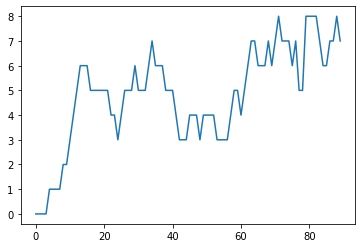

In [10]:
plt.plot(no_jobs_waiting)

plt.show()

In [11]:
process_time  = []
waiting_time = []
for job in job_queue:
    if job_queue[job]['status_flag'][0]:
        waiting_time.append(job_queue[job]['entry_time'][0] - job_queue[job]['arrival_time'][0])
        process_time.append(job_queue[job]['exit_time'][0] - job_queue[job]['entry_time'][0])

print("Mean Waiting Time: ", np.mean(waiting_time))
print("Mean Process Time: ", np.mean(process_time))
    

Mean Waiting Time:  12.6317210038503
Mean Process Time:  9.432143425941467
